In [1]:
!pip install google-cloud-aiplatform --quiet

In [2]:
!pip install joblib --quiet

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import urllib.request
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account
import vertexai
from vertexai.language_models import TextGenerationModel
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

In [4]:
from google.colab import auth
auth.authenticate_user()

In [5]:
project_id = "861764395485" #string com o nome do projeto, parametro para instanciar o bigquery
location = "us-central1"

clientbq = bigquery.Client(project=project_id)
vertexai.init(project=project_id, location=location)

In [6]:
## função para realizar busca no bigquery e transformar o retorno em um data frame
def busca_bigquery(consulta):
  query_job = clientbq.query(consulta)  # Faz a requisição na API do BigQuery.
  df = query_job.to_dataframe()
  return df


In [7]:
# teste da função para conhecer as colunas do dataset
teste = '''
select * from bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2021 limit 100;
'''

busca_bigquery(teste)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,airport_fee,total_amount,pickup_location_id,dropoff_location_id,data_file_year,data_file_month
0,2,2021-06-02 12:34:29+00:00,2021-06-02 12:36:11+00:00,1,0E-9,1.0,N,2,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,193,193,2021,6
1,1,2021-06-11 10:28:39+00:00,2021-06-11 11:13:20+00:00,2,16.700000000,2.0,N,3,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,186,132,2021,6
2,2,2021-06-11 17:43:28+00:00,2021-06-11 17:43:48+00:00,1,0.050000000,2.0,N,2,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,163,163,2021,6
3,1,2021-06-02 11:07:57+00:00,2021-06-02 11:07:57+00:00,1,0E-9,2.0,Y,3,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,264,264,2021,6
4,2,2021-06-18 11:28:16+00:00,2021-06-18 11:31:14+00:00,1,0E-9,1.0,N,1,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,193,193,2021,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,2021-06-16 15:14:16+00:00,2021-06-16 15:15:17+00:00,1,0E-9,1.0,N,1,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,193,193,2021,6
96,1,2021-06-04 13:57:11+00:00,2021-06-04 13:57:11+00:00,1,0E-9,1.0,Y,4,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,132,264,2021,6
97,1,2021-06-05 13:10:15+00:00,2021-06-05 13:10:15+00:00,4,0E-9,1.0,N,3,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,132,264,2021,6
98,2,2021-06-07 17:33:15+00:00,2021-06-07 17:33:23+00:00,1,0E-9,2.0,N,2,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,249,249,2021,6


In [8]:
#Em 2011, como foram as quantidades de corridas de acordo com o dia da semana? (0,5)
a = '''
SELECT
  CASE
    EXTRACT(DAYOFWEEK from pickup_datetime)
      WHEN 1 THEN 'Domingo'
      WHEN 2 THEN 'Segunda'
      WHEN 3 THEN 'Terça'
      WHEN 4 THEN 'Quarta'
      WHEN 5 THEN 'Quinta'
      WHEN 6 THEN 'Sexta'
      WHEN 7 THEN 'Sábado'
      ELSE 'Dia Inválido'
  END dia_da_semana,
COUNT(*) AS total_por_dia
FROM bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2011
GROUP BY
dia_da_semana
ORDER BY
total_por_dia DESC;
'''

df = busca_bigquery(a)
display(df)

,dia_da_semana,total_por_dia
0,Sexta,27265076
1,Sábado,26805827
2,Quinta,26659106
3,Quarta,25913572
4,Terça,25193101
5,Segunda,22921512
6,Domingo,22129054


In [9]:
fig = px.bar(df, x='dia_da_semana', y='total_por_dia')
fig.show()

In [10]:
#Em 2011, como foram os valores das corridas de acordo com o dia da semana? (0,5)
b = '''
SELECT -- questao b
  CASE
    EXTRACT(DAYOFWEEK from pickup_datetime)
      WHEN 1 THEN 'Domingo'
      WHEN 2 THEN 'Segunda'
      WHEN 3 THEN 'Terça'
      WHEN 4 THEN 'Quarta'
      WHEN 5 THEN 'Quinta'
      WHEN 6 THEN 'Sexta'
      WHEN 7 THEN 'Sábado'
      ELSE 'Dia Inválido'
  END dia_da_semana,
  AVG(total_amount) as media_valor_dia_da_semana,
  SUM(total_amount) as soma_valor_dia_da_semana_durante_ano
  FROM bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2011
  GROUP BY
  dia_da_semana
  ORDER BY
  media_valor_dia_da_semana DESC;
  '''

df = busca_bigquery(b)
display(df)

,dia_da_semana,media_valor_dia_da_semana,soma_valor_dia_da_semana_durante_ano
0,Quinta,12.468213276,332391419.360000000
1,Sexta,12.406703844,338269723.220000000
2,Domingo,12.338573707,273040963.850000000
3,Segunda,12.287155696,281640186.730000000
4,Quarta,12.250278408,317448471.550000000
5,Terça,12.152075068,306148454.560000000
6,Sábado,11.697844634,313570399.530000000


In [11]:
## instanciando e plotando grafico fig

fig = go.Figure(data=[
    go.Bar(name='Media', x=df['dia_da_semana'], y=df['media_valor_dia_da_semana']),
])

fig.update_layout(barmode='group', title_text='Média Dos Valores das corridas por dia da semana durante o ano')
fig.show()

## instanciando e plotando grafico fig2
fig2 = go.Figure(data=[
    go.Bar(name='Soma', x=df['dia_da_semana'], y=df['soma_valor_dia_da_semana_durante_ano']),
    ])

fig2.update_layout(barmode='group',title_text='Soma Dos Valores das corridas por dia da semana durante o ano')
fig2.show()



In [12]:
# Em 2011, como foram os valores das corridas de acordo com a quantidade de passageiros? (0,25)

c = '''
SELECT -- questao c
  passenger_count as Quantidade_de_passageiros,
  COUNT(*) as qtd_corridas_por_qtd_passageiros,
  AVG(total_amount) as media_valor_dia_da_semana,
  SUM(total_amount) as soma_valor_dia_da_semana_durante_ano
  FROM bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2011
  GROUP BY
  passenger_count
  ORDER BY
  passenger_count DESC;
'''

df = busca_bigquery(c)
display(df)

,Quantidade_de_passageiros,qtd_corridas_por_qtd_passageiros,media_valor_dia_da_semana,soma_valor_dia_da_semana_durante_ano
0,255,1,11.700000000,11.700000000
1,250,1,13.800000000,13.800000000
2,225,1,16.000000000,16.000000000
3,223,1,9.500000000,9.500000000
4,211,1,7.000000000,7.000000000
5,208,125,7.711200000,963.900000000
6,193,1,7.500000000,7.500000000
7,129,3,10.433333333,31.300000000
8,97,1,9.900000000,9.900000000
9,70,1,10.700000000,10.700000000


In [13]:
## instanciando e plotando grafico fig2
fig = go.Figure(data=[
    go.Bar(name='Soma', x=df['Quantidade_de_passageiros'], y=df['media_valor_dia_da_semana']),
    ])

fig.update_layout(barmode='group',title_text='Média dos Valores das corridas por quantidade de passageiro na corrida durante o ano')
fig.show()

In [14]:
#– Em 2011, como foram as gorjetas de acordo com o dia da semana? (0,25)

d = '''
SELECT --questao d
  CASE
    EXTRACT(DAYOFWEEK from pickup_datetime)
      WHEN 1 THEN 'Domingo'
      WHEN 2 THEN 'Segunda'
      WHEN 3 THEN 'Terça'
      WHEN 4 THEN 'Quarta'
      WHEN 5 THEN 'Quinta'
      WHEN 6 THEN 'Sexta'
      WHEN 7 THEN 'Sábado'
      ELSE 'Dia Inválido'
  END dia_da_semana,
  COUNT(*) as quantidade_corridas,
  AVG(tip_amount) as media_valor_tips_dia_da_semana,
  SUM(tip_amount) as soma_valor_tips_dia_da_semana
  FROM bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2011
  GROUP BY
  dia_da_semana
  ORDER BY
  quantidade_corridas DESC;
'''

df = busca_bigquery(d)
display(df)

,dia_da_semana,quantidade_corridas,media_valor_tips_dia_da_semana,soma_valor_tips_dia_da_semana
0,Sexta,27265076,0.970512825,26461105.930000000
1,Sábado,26805827,0.837212413,22442171.100000000
2,Quinta,26659106,1.023284883,27279860.170000000
3,Quarta,25913572,1.011312916,26206730.070000000
4,Terça,25193101,0.989078522,24917955.090000000
5,Segunda,22921512,0.971384134,22265593.090000000
6,Domingo,22129054,0.911880565,20179054.260000000


In [15]:
## instanciando e plotando grafico fig2
fig = go.Figure(data=[
    go.Bar(name='Media', x=df['dia_da_semana'], y=df['media_valor_tips_dia_da_semana']),
    ])

fig.update_layout(barmode='group',title_text='Media dos valores das gorjetas por dia da semana')
fig.show()

In [16]:
# Ainda neste conjunto de dados, avalie a evolução ano a ano até 2021
# Total absoluto de corridas (0,5)

e = '''
SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2011`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2011 AND 2011
GROUP BY
  year

UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2012`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2012 AND 2012
GROUP BY
  year

UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2013`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2013 AND 2013
GROUP BY
  year

UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2014`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2014 AND 2014
GROUP BY
  year

UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2015 AND 2015
GROUP BY
  year

  UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2016 AND 2016
GROUP BY
  year

  UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2017 AND 2017
GROUP BY
  year

UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2018 AND 2018
GROUP BY
  year

UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2019`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2019 AND 2019
GROUP BY
  year

UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2020`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2020 AND 2020
GROUP BY
  year

  UNION ALL

SELECT
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2021`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2021 AND 2021
GROUP BY
  year
ORDER BY
  year;
  '''

df = busca_bigquery(e)
display(df)


,year,total_trips
0,2011,176887248
1,2012,256415130
2,2013,185787446
3,2014,275921951
4,2015,146039220
5,2016,131131794
6,2017,113500148
7,2018,102870094
8,2019,84596991
9,2020,24648801


In [17]:
## instanciando e plotando grafico
fig = go.Figure()

# Adiciona uma barra ao gráfico para a média
fig.add_trace(go.Bar(name='Ano', x=df['year'], y=df['total_trips']))

# Atualize o layout do gráfico
fig.update_layout(barmode='group', title='Total Absoluto de Corridas (2011 a 2021)',
                  xaxis=dict(title='Ano', tickmode='linear', tick0=df['year'].min(), dtick=1),
                  yaxis=dict(title='Total de Corridas'))

fig.show()

In [18]:
#Total relativo de corridas por dia da semana (0,5)

query_total_relativo = """
SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2011`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2011 AND 2011
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2012`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2012 AND 2012
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2013`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2013 AND 2013
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2014`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2014 AND 2014
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2015 AND 2015
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2016 AND 2016
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2017 AND 2017
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2018 AND 2018
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2019`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2019 AND 2019
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2020`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN  2020 AND 2020
GROUP BY
  dia_da_semana, year

UNION ALL

SELECT
  CASE EXTRACT(DAYOFWEEK FROM pickup_datetime)
    WHEN 1 THEN 'Domingo'
    WHEN 2 THEN 'Segunda'
    WHEN 3 THEN 'Terça'
    WHEN 4 THEN 'Quarta'
    WHEN 5 THEN 'Quinta'
    WHEN 6 THEN 'Sexta'
    WHEN 7 THEN 'Sábado'
    ELSE 'Dia Inválido'
  END AS dia_da_semana,
  EXTRACT(YEAR FROM pickup_datetime) AS year,
  COUNT(*) AS total_trips
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2021`
WHERE
  EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2021 AND 2021
GROUP BY
  dia_da_semana, year
ORDER BY
  year, dia_da_semana;
"""

df = busca_bigquery(query_total_relativo)
display(df)

,dia_da_semana,year,total_trips
0,Domingo,2011,22129054
1,Quarta,2011,25913572
2,Quinta,2011,26659106
3,Segunda,2011,22921512
4,Sexta,2011,27265076
...,...,...,...
72,Quinta,2021,4786495
73,Segunda,2021,4025272
74,Sexta,2021,4870381
75,Sábado,2021,4459873


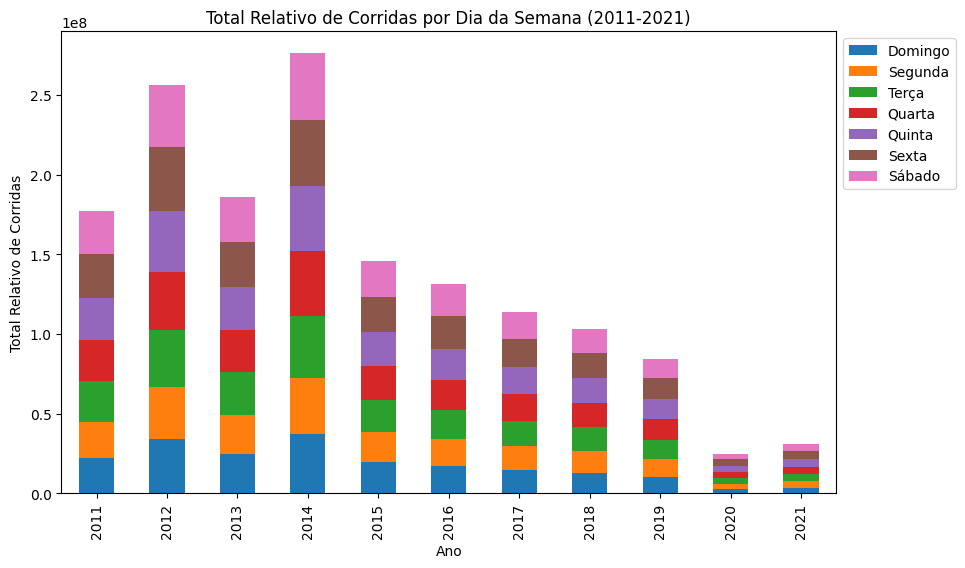

In [19]:
## instanciando e plotando grafico
df_pivot = df.pivot(index='year', columns='dia_da_semana', values='total_trips')

# Reordena as colunas para que os dias da semana apareçam na ordem correta
dias_da_semana_ordem = ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado']
df_pivot = df_pivot[dias_da_semana_ordem]

ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adiciona rótulos e título ao gráfico
plt.xlabel('Ano')
plt.ylabel('Total Relativo de Corridas')
plt.title('Total Relativo de Corridas por Dia da Semana (2011-2021)')

# legenda fora do gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [20]:
#Total relativo de corridas por período do dia (1,5)

query_total_por_periodo ="""
WITH trips_by_period AS (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2011`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2011 AND 2011
  GROUP BY
    year, hour_of_day
)

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM
  trips_by_period
GROUP BY
  year, periodo_do_dia

UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2012`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2012 AND 2012
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2013`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2013 AND 2013
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2014`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2014 AND 2014
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2015 AND 2015
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2016 AND 2016
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2017 AND 2017
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

  UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2018 AND 2018
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2019`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2019 AND 2019
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2020`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2020 AND 2020
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

UNION ALL

SELECT
  year,
  CASE
    WHEN hour_of_day >= 5 AND hour_of_day < 12 THEN 'Manhã'
    WHEN hour_of_day >= 12 AND hour_of_day < 18 THEN 'Tarde'
    WHEN hour_of_day >= 18 AND hour_of_day < 24 THEN 'Noite'
    ELSE 'Outro'
  END AS periodo_do_dia,
  SUM(total_trips) AS total_trips
FROM (
  SELECT
    EXTRACT(YEAR FROM pickup_datetime) AS year,
    EXTRACT(HOUR FROM pickup_datetime) AS hour_of_day,
    COUNT(*) AS total_trips
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2021`
  WHERE
    EXTRACT(YEAR FROM pickup_datetime) BETWEEN 2021 AND 2021
  GROUP BY
    year, hour_of_day
)
GROUP BY
  year, periodo_do_dia

ORDER BY
  year, periodo_do_dia;
"""

df = busca_bigquery(query_total_por_periodo)
display(df)

,year,periodo_do_dia,total_trips
0,2011,Manhã,44442495
1,2011,Noite,60622200
2,2011,Outro,21066835
3,2011,Tarde,50755718
4,2012,Manhã,64297625
5,2012,Noite,88318929
6,2012,Outro,30564638
7,2012,Tarde,73233938
8,2013,Manhã,46451582
9,2013,Noite,64275793


In [21]:
## instanciando e plotando grafico
fig = go.Figure()

# Adicionando barras ao gráfico para cada período
for periodo in df['periodo_do_dia'].unique():
    periodo_data = df[df['periodo_do_dia'] == periodo]
    fig.add_trace(go.Bar(name=periodo, x=periodo_data['year'], y=periodo_data['total_trips']))

fig.update_layout(barmode='group', title_text='Total relativo de corridas por período do dia (2011 a 2021)')

# Adicionando rótulos aos anos no eixo X
fig.update_layout(xaxis=dict(tickmode='array', tickvals=df['year'].unique(), ticktext=df['year'].unique()))

fig.show()

## **Parte 02 - Serviços de ML na nuvem para servir modelos**

In [22]:

modelo_2021 = '''
select * from bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2021 limit 100000;
'''
df_modelo = busca_bigquery(modelo_2021)


# Valor que você está verificando se corresponde
valor_correspondente = '0E-9'

# Substituir por 0 se corresponder, senão por 1
df_modelo['tip_amount'] = df_modelo['tip_amount'].apply(lambda x: 0 if float(x) == float(valor_correspondente) else 1)

df_modelo['pickup_datetime'] = df_modelo['pickup_datetime'].dt.day_name()

# Aplicar One-Hot Encoding
one_hot_encoded = pd.get_dummies(df_modelo['pickup_datetime'])

# Concatenar as colunas one-hot encoding ao DataFrame original
df_modelo = pd.concat([df_modelo, one_hot_encoded], axis=1)

##dropando algumas colunas

df_modelo = df_modelo.drop(['pickup_datetime','dropoff_datetime','vendor_id','store_and_fwd_flag','pickup_location_id','dropoff_location_id'], axis=1)
df_modelo = df_modelo.dropna()
## realizando o split da base do modelo


y = df_modelo['tip_amount']
X = df_modelo.drop(['tip_amount'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [23]:
# Inicializar o modelo de Random Forest
random_forest = RandomForestClassifier(n_estimators=5, random_state=42)

# Treinar o modelo
random_forest.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
predictions = random_forest.predict(X_test)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Acurácia do modelo de Random Forest: {accuracy:.2f}')

Acurácia do modelo de Random Forest: 0.99


In [24]:
#IMPORT DO MODELO

joblib.dump(random_forest, 'random_forest_treinado1.pkl')

['random_forest_treinado1.pkl']

In [25]:
import sklearn
print(sklearn.__version__)

1.3.2


# **Parte 03 - Integração com modelos LLM**

In [26]:
# Consulta ao BigQuery para obter os dados necessários
query_analise_interpretativa = """
select * from bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2011 limit 50;
"""
# Execute a nova consulta
df_analise = busca_bigquery(query_analise_interpretativa)

# Montagem do prompt dinâmico
prompt_teste = '''
Faça uma análise interpretativa sobre as corridas de táxi de NY considerando:

- Em 1998 foram 44565464 de viagens e em 1999 foram 64565464 de viagens;
- O tempo médio de corridas em 1998 era de 48 minutos e em 1999 era de 69 minutos;
- As viagens em 1998 se concentravam nos dias da semana, enquanto que em 1999 a distribuição era
mais uniforme.
'''

prompt = '''
Faça uma análise interpretativa sobre as corridas de táxi de NY considerando:

- Em 2011, quinta-feira e sexta-feira foram os dias com a maior média de valor por corrida;
- No ano de 2014 foi o ano que mais se teve corridas no periodo noturno;
- Em 2020, foi o ano que menos se teve corridas de taxi;

'''

## parametros e instanciando modelo
parameters = {
    "candidate_count": 1,
    "max_output_tokens": 1024,
    "temperature": 0.2,
    "top_p": 0.8,
    "top_k": 40
}

model = TextGenerationModel.from_pretrained("text-bison")

# Exibição do prompt
print(prompt)



Faça uma análise interpretativa sobre as corridas de táxi de NY considerando:

- Em 2011, quinta-feira e sexta-feira foram os dias com a maior média de valor por corrida;
- No ano de 2014 foi o ano que mais se teve corridas no periodo noturno;
- Em 2020, foi o ano que menos se teve corridas de taxi;




In [27]:
## fazendo a chamada do modelo com os prompts e parametros já setados
response = model.predict(
    prompt,
    **parameters
)
print(f"Response from Model: {response.text}")

Response from Model:  **Análise interpretativa sobre as corridas de táxi de NY**

**1. Em 2011, quinta-feira e sexta-feira foram os dias com a maior média de valor por corrida**

Isso pode ser explicado por vários fatores, incluindo:

* **Aumento da demanda por táxis nesses dias:** Quinta-feira e sexta-feira são tipicamente dias de maior atividade social, com mais pessoas saindo para jantar, beber e se divertir. Isso pode levar a um aumento na demanda por táxis, o que pode levar a preços mais altos.
* **Maior disponibilidade de táxis nesses dias:** Quinta-feira e sexta-feira também são tipicamente dias em que há mais táxis disponíveis nas ruas. Isso pode ser devido ao fato de que muitos motoristas de táxi trabalham em turnos de fim de semana e, portanto, estão mais propensos a estar disponíveis nesses dias.
* **Maior distância percorrida nesses dias:** Quinta-feira e sexta-feira também são tipicamente dias em que as pessoas percorrem distâncias maiores em táxis. Isso pode ser devido ao